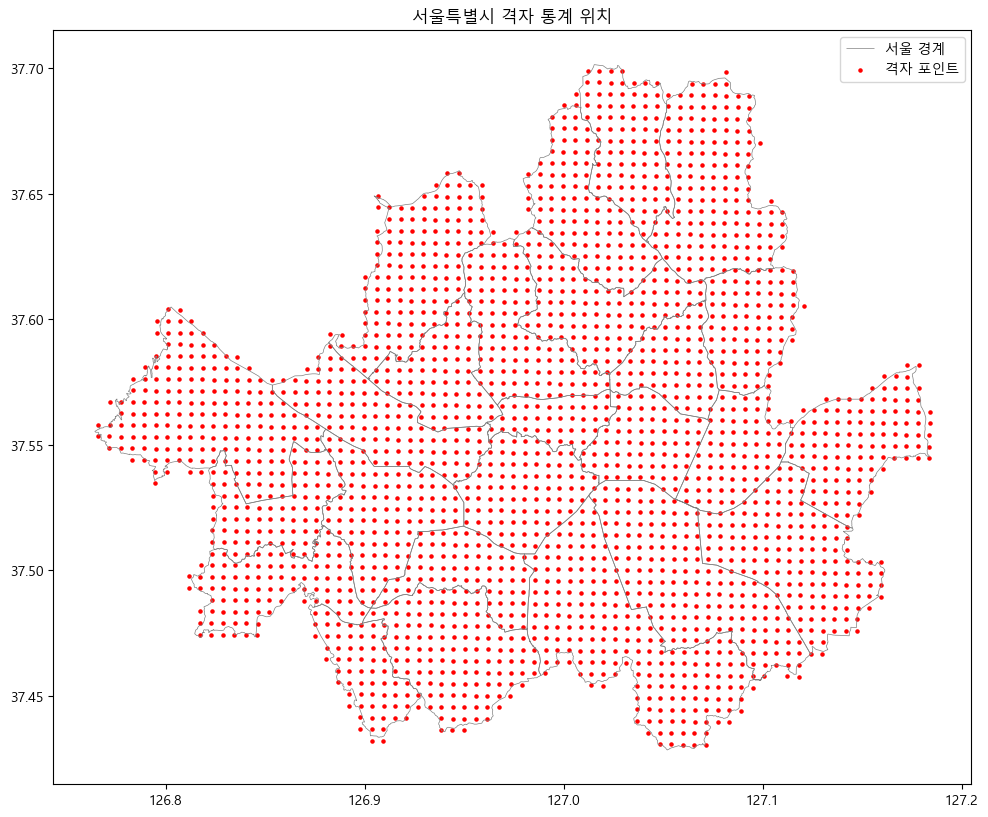

✅ CSV 저장 완료: 서울특별시_WBGT_입력기초.csv


In [ ]:
import os
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from dotenv import load_dotenv
from io import StringIO

# 1 환경 설정
load_dotenv()
key = os.getenv("KMA_API_KEY")
url = "https://apihub.kma.go.kr/api/typ01/url/sfc_obs_nc_sts_area_api.php"
admcode, year = "11000000", 2023  # ✅ 서울특별시

# 2 변수별 데이터 조회 및 병합
vars = ["ta_avg", "td_avg", "hm_avg"]
dfs = {}
for v in vars:
    r = requests.get(url, params={"tm1": year, "tm2": year, "admcode": admcode, "disp": 0, "reduce": 0, "authKey": key, "var": v})
    df = pd.read_csv(StringIO(r.text)).rename(columns={str(year): v, "latitude": "lat", "longitude": "lon"})
    dfs[v] = df

df = dfs[vars[0]]
for v in vars[1:]:
    df = df.merge(dfs[v][["lat", "lon", v]], on=["lat", "lon"], how="left")

# 3 GeoDataFrame 변환
df["geometry"] = df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 4 서울 전체 시군구 + 서울시 필터링
shp = gpd.read_file("data/SHP/서울특별시/LARD_ADM_SECT_SGG_11_202505.shp").to_crs("EPSG:4326")
seoul_all = shp.copy()
seoul = shp[shp["SGG_NM"].str.contains("서울")]  # 보통 "서울" 포함되는 행이 없으니 전체 사용도 OK

# 5 시각화
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

fig, ax = plt.subplots(figsize=(10, 10))
seoul_all.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, label="서울 경계")
gdf.plot(ax=ax, color="red", markersize=5, label="격자 포인트")

plt.title("서울특별시 격자 통계 위치")
plt.legend()
plt.tight_layout()
plt.show()

# ✅ CSV 저장
df.to_csv("data/CSV/서울특별시_WBGT_입력기초.csv", index=False)
print("✅ CSV 저장 완료: 서울특별시_WBGT_입력기초.csv")


In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree

# 1. 입력 데이터
df = pd.read_csv("data/CSV/서울특별시_WBGT_입력기초.csv")

# 2. SWRAD 연평균 NetCDF 로드
ds_latlon = xr.open_dataset("data/SWRAD/gk2a_ko020lc_latlon.nc")
lat = ds_latlon["lat"].values
lon = ds_latlon["lon"].values

swrad = np.load("data/SWRAD/mean_swrad.npz")
ASR = swrad["ASR"]
DSR = swrad["DSR"]
RSR = swrad["RSR"]

# 3. KDTree를 이용해 가장 가까운 격자 추출
latlon_grid = np.column_stack([lat.ravel(), lon.ravel()])
tree = cKDTree(latlon_grid)

query_points = df[["lat", "lon"]].values
_, indexes = tree.query(query_points)
i, j = np.unravel_index(indexes, lat.shape)

df["ASR"] = ASR[i, j]
df["DSR"] = DSR[i, j]
df["RSR"] = RSR[i, j]

# 4. Tnwb 계산 (Stull 2011)
Ta = df["ta_avg"]
RH = df["hm_avg"]

Tnwb = (
    Ta * np.arctan(0.151977 * np.sqrt(RH + 8.313659))
    + np.arctan(Ta + RH)
    - np.arctan(RH - 1.676331)
    + 0.00391838 * RH ** 1.5 * np.arctan(0.023101 * RH)
    - 4.686035
)
df["Tnwb"] = Tnwb

# 5. Tg 근사 (복사량 기반)
df["Tg"] = df["ta_avg"] + 0.02 * np.sqrt(df["DSR"])

# 6. WBGT 계산 (실외 기준)
df["WBGT"] = 0.7 * df["Tnwb"] + 0.2 * df["Tg"] + 0.1 * df["ta_avg"]

# 7. 저장
df.to_csv("data/CSV/서울특별시_WBGT_계산결과.csv", index=False)

C:\Users\dodam\AppData\Local\Temp\ipykernel_20948\56458471.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  yeongcheon = gdf[gdf["SGG_NM"].str.contains("서울")].geometry.unary_union


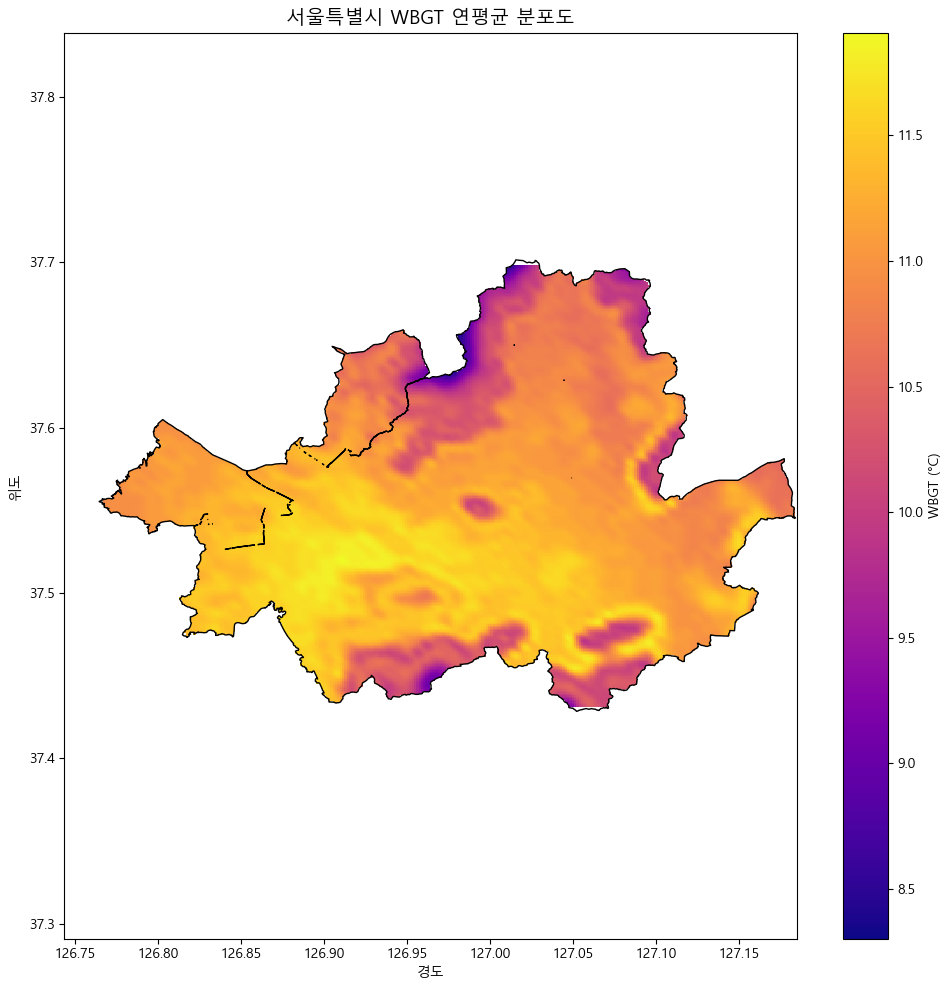

In [21]:
from shapely.geometry import Point
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# 1. 입력
df = pd.read_csv("data/CSV/서울특별시_WBGT_계산결과.csv")
lon, lat, wbgt = df["lon"], df["lat"], df["WBGT"]

# 2. 그리드 생성
grid_lon = np.linspace(lon.min(), lon.max(), 300)
grid_lat = np.linspace(lat.min(), lat.max(), 300)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)
grid_z = griddata((lon, lat), wbgt, (grid_x, grid_y), method="cubic")

# 3. 영천시 경계 불러오기
gdf = gpd.read_file("data/SHP/서울특별시/LARD_ADM_SECT_SGG_11_202505.shp").to_crs("EPSG:4326")
yeongcheon = gdf[gdf["SGG_NM"].str.contains("서울")].geometry.unary_union

# 4. 마스크 생성: 경계 내부만 True
mask = np.array([
    [yeongcheon.contains(Point(x, y)) for x in grid_lon]
    for y in grid_lat
])

# 5. 마스킹된 값으로 처리
masked_z = np.where(mask, grid_z, np.nan)

# 6. 시각화
fig, ax = plt.subplots(figsize=(10, 10))
pcm = ax.pcolormesh(grid_x, grid_y, masked_z, cmap="plasma", shading="auto")

gpd.GeoSeries(yeongcheon).boundary.plot(ax=ax, edgecolor="black", linewidth=1)

plt.colorbar(pcm, ax=ax, label="WBGT (°C)")
ax.set_title("서울특별시 WBGT 연평균 분포도", fontsize=14)
ax.set_xlabel("경도")
ax.set_ylabel("위도")
plt.axis("equal")
plt.tight_layout()
plt.savefig("data/PNG/서울특별시_WBGT.png")
plt.show()